In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Step 1: Load the Dataset
file_path = 'weather_data.csv'  # Path to uploaded file
data = pd.read_csv(file_path)

# Convert Date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Display dataset summary
print(data.head())
print(data.info())

        date  temperature
0 2014-01-01    10.248357
1 2014-01-02     9.950428
2 2014-01-03    10.362958
3 2014-01-04    10.820167
4 2014-01-05     9.961091
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2557 non-null   datetime64[ns]
 1   temperature  2557 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.1 KB
None


In [17]:
# Step 2: Preprocess the Data
# Normalize the Temperature column
scaler = MinMaxScaler()
data['temperature'] = scaler.fit_transform(data[['temperature']])

# Create sequences for LSTM
time_steps = 30
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        seq = data[i:i + time_steps]
        sequences.append(seq)
    return np.array(sequences)

temperature_sequences = create_sequences(data['temperature'].values, time_steps)

# Split into training and testing sets
train_size = int(0.8 * len(temperature_sequences))
X_train = temperature_sequences[:train_size]
X_test = temperature_sequences[train_size:]

# Reshape for LSTM input (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [18]:

# Step 3: Build the LSTM Autoencoder
input_dim = X_train.shape[2]  # Number of features
latent_dim = 8  # Latent dimension for encoding

# Encoder
inputs = Input(shape=(time_steps, input_dim))
encoded = LSTM(latent_dim, activation='relu', return_sequences=False)(inputs)
encoded = RepeatVector(time_steps)(encoded)

# Decoder
decoded = LSTM(latent_dim, activation='relu', return_sequences=True)(encoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

# Autoencoder model
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [19]:
# Step 4: Train the Model
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.2602 - val_loss: 0.0952
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0467 - val_loss: 0.0157
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0128 - val_loss: 0.0106
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0091 - val_loss: 0.0065
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0

In [24]:
# Step 5: Anomaly Detection
# Predict on test data
X_test_pred = autoencoder.predict(X_test)

# Calculate reconstruction error
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=(1, 2))

# Define a threshold for anomalies (95th percentile of reconstruction error)
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

# Identify anomalous dates
anomalous_dates = data['date'][time_steps + train_size:len(data)][anomalies]
anomalous_values = data['temperature'][time_steps + train_size:len(data)][anomalies]

# Display Reconstruction Errors and Anomalies
results = pd.DataFrame({
    'Date': data['date'][time_steps + train_size:len(data)],
    'Reconstruction Error': mse,
    'Anomaly': ['Yes' if anomaly else 'No' for anomaly in anomalies]
})

# Display errors with anomalies
print("Reconstruction Errors and Anomalies:")
print(results.head(20))  # Display the first 20 rows

# Display anomalous dates specifically
if not anomalous_dates.empty:
    print("\nDetected Anomalies:")
    for date, value in zip(anomalous_dates, anomalous_values):
        print(f"Date: {date}, Temperature: {value}")
else:
    print("\nNo anomalies detected.")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Reconstruction Errors and Anomalies:
           Date  Reconstruction Error Anomaly
2051 2019-08-14              0.006732     Yes
2052 2019-08-15              0.006819     Yes
2053 2019-08-16              0.007159     Yes
2054 2019-08-17              0.007271     Yes
2055 2019-08-18              0.006641     Yes
2056 2019-08-19              0.006588     Yes
2057 2019-08-20              0.006539     Yes
2058 2019-08-21              0.006546     Yes
2059 2019-08-22              0.006603     Yes
2060 2019-08-23              0.006544     Yes
2061 2019-08-24              0.006655     Yes
2062 2019-08-25              0.006547     Yes
2063 2019-08-26              0.006507     Yes
2064 2019-08-27              0.006405     Yes
2065 2019-08-28              0.006238      No
2066 2019-08-29              0.006036      No
2067 2019-08-30              0.006607     Yes
2068 2019-08-31              0.006692     Yes
2069 2019-09-01              0.006838     Yes
2070

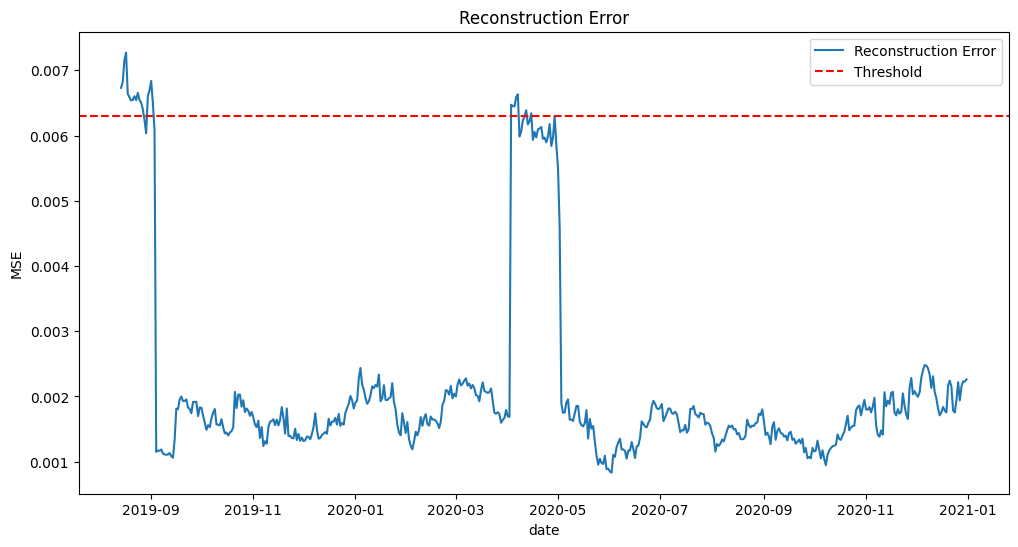

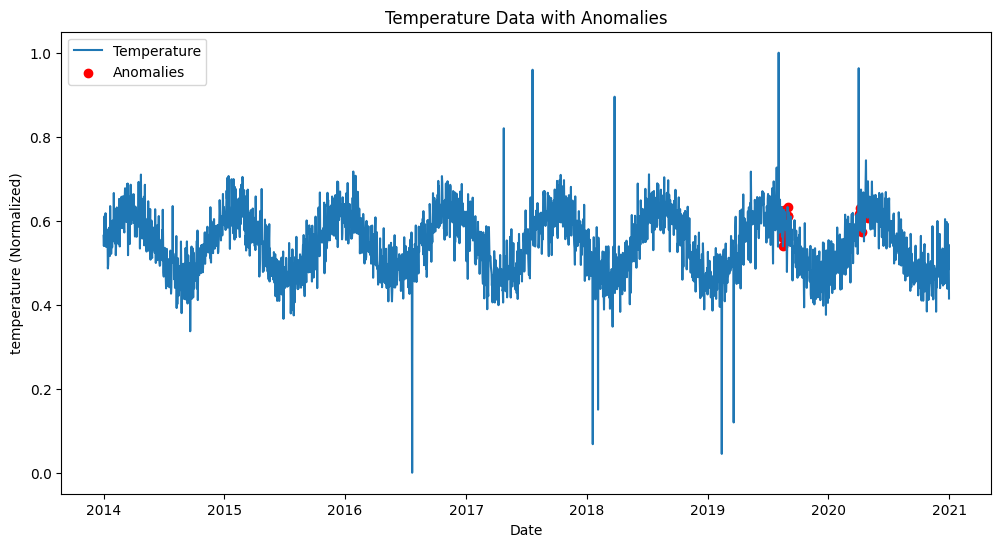

In [21]:


# Step 6: Visualize the Results
# Plot reconstruction error
plt.figure(figsize=(12, 6))
plt.plot(data['date'][time_steps + train_size:len(data)], mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error')
plt.xlabel('date')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Highlight anomalies on temperature data
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['temperature'], label='Temperature')
plt.scatter(anomalous_dates, anomalous_values, color='r', label='Anomalies')
plt.title('Temperature Data with Anomalies')
plt.xlabel('Date')
plt.ylabel('temperature (Normalized)')
plt.legend()
plt.show()



1. Data Loading and Preprocessing:
   Loads weather data from a CSV file .
   Converts the 'date' column to datetime objects.
   Normalizes the 'temperature' column using minmaxscalar to a range between 0 and 1.  This is crucial for neural networks.
   Creates sequences of temperature data using a sliding window approach .  This transforms the data into a format suitable for LSTM.
   Splits the data into training and testing sets.

2. LSTM Autoencoder Model Building:
   Defines an LSTM autoencoder model using Keras.  The encoder compresses the input sequence into a lower-dimensional representation (latent space), and the decoder reconstructs the original sequence.
   The model is compiled with the Adam optimizer and Mean Squared Error (MSE) loss.  MSE is used to measure the difference between the original and reconstructed sequences.

3. Model Training:
   Trains the autoencoder model on the training data.
   Uses a validation split to monitor the model's performance on unseen data during training.

4. Anomaly Detection:
   Uses the trained model to predict the temperature sequences in the test set.
   Calculates the reconstruction error (MSE) between the original and predicted sequences.  Large errors indicate anomalies.
   Sets an anomaly threshold based on the 95th percentile of the reconstruction errors.  Any error above this threshold is flagged as an anomaly.

5. Visualization:
   Plots the reconstruction error over time, highlighting the threshold.  Points above the threshold are potential anomalies.
   Plots the original temperature data and marks the detected anomalies.

